In [1]:
import numpy as np 
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam


2024-11-11 21:06:11.130659: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 21:06:11.143258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731355571.151991 4031747 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731355571.154583 4031747 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 21:06:11.164753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def preprocess_data(data, labels):
    data = data / 255.0

    if len(data.shape) == 3:
        data = data.reshape(-1, data.shape[1], data.shape[2], 1)

    fractional_hours = (labels[:, 0]) + labels[:, 1] / 60.0

    labels_processed = fractional_hours / 12.0  # 12 hours in an analogue clock
    
    data_train, data_temp, labels_train, labels_temp = train_test_split(
        data, labels_processed, test_size=0.2, random_state=42, shuffle=True
    )
    data_val, data_test, labels_val, labels_test = train_test_split(
        data_temp, labels_temp, test_size=0.5, random_state=42
    )
    return data_train, labels_train, data_test, labels_test, data_val, labels_val


def common_sense_metric(y_true, y_pred):
    y_true = y_true * 12.0
    y_pred = y_pred * 12.0

    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 12.0 - linear_diff)

    return tf.reduce_mean(circular_diff)


def common_sense_loss(y_true, y_pred):
    y_true = y_true * 12.0
    y_pred = y_pred * 12.0

    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 12.0 - linear_diff)

    return tf.reduce_mean(tf.square(circular_diff))


def format_error_in_hours_and_minutes(error_in_hours):
    hours = int(error_in_hours)
    minutes = int((error_in_hours - hours) * 60)
    return f"{hours} hours and {minutes} minutes"


def plot_training_validation_mae(history):
    train_mae = history.history['common_sense_metric']
    val_mae = history.history['val_common_sense_metric']
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean absolute error (hours)')
    plt.title('Training and validation mean absolute error')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_error_distribution(y_true, y_pred, num_bins=30):
    y_true = y_true * 12.0
    y_pred = y_pred.ravel() * 12.0
    
    linear_diff = np.abs(y_true - y_pred)
    circular_error = np.abs(np.minimum(linear_diff, 12.0 - linear_diff))

    plt.figure(figsize=(10, 6))
    plt.hist(circular_error, bins=num_bins, color='skyblue', edgecolor='black')
    plt.title('Distribution of mean absolute errors')
    plt.xlabel('Mean absolute error (hours)')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

    # Statistics of the error distribution
    mean_error_formatted = format_error_in_hours_and_minutes(np.mean(circular_error))
    median_error_formatted = format_error_in_hours_and_minutes(np.median(circular_error))
    max_error_formatted = format_error_in_hours_and_minutes(np.max(circular_error))

    print(f"Mean Error: {mean_error_formatted}")
    print(f"Median Error: {median_error_formatted}")
    print(f"Max Error: {max_error_formatted}")


/vol/home/s4484010/miniforge3/envs/IDL2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731355579.139483 4031747 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6291 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,049 (1.17 MB)

 Trainable params: 306,049 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1731355580.389877 4032005 service.cc:148] XLA service 0x7a692c00dab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731355580.389901 4032005 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-11 21:06:20.408650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731355580.497202 4032005 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-11 21:06:21.697354: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 58/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - common_sense_metric: 2.9452 - loss: 11.2897

I0000 00:00:1731355582.372214 4032005 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - common_sense_metric: 2.6706 - loss: 11.8080 - val_common_sense_metric: 3.0242 - val_loss: 12.1107
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - common_sense_metric: 2.7033 - loss: 12.1737 - val_common_sense_metric: 3.0236 - val_loss: 12.1097
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.9993 - loss: 12.0349 - val_common_sense_metric: 3.0115 - val_loss: 12.0386
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.9692 - loss: 11.8920 - val_common_sense_metric: 3.0359 - val_loss: 12.1629
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.9644 - loss: 11.8377 - val_common_sense_metric: 2.9894 - val_loss: 11.8952
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.8361 - loss: 11.9500 - val_common_sense_metric: 3.0396 - val_loss: 12.2138
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.8352 - loss: 11.

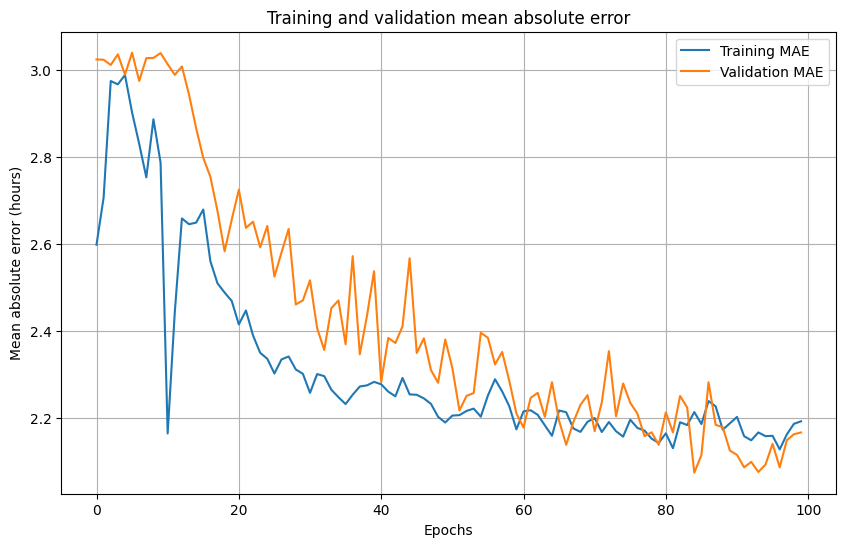

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


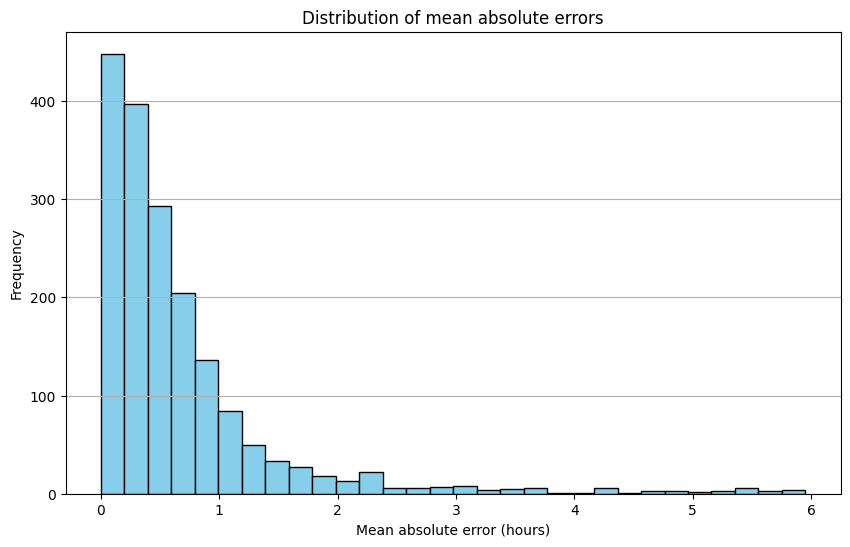

Mean Error: 0 hours and 40 minutes
Median Error: 0 hours and 26 minutes
Max Error: 5 hours and 57 minutes


In [3]:
def create_cnn(image_length, data, labels):    
    tf.keras.backend.clear_session()
    gc.collect()
    data_train, labels_train, data_test, labels_test, data_val, labels_val = preprocess_data(data, labels)

    # CNN for time components (regression)
    model = Sequential([
        # Layer 0
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_length, image_length, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        # Layer 1
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        # Layer 2
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        # Layer 3
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1) 
    ])

    optimizer = Adam(learning_rate=1e-4)
    
    model.summary() 

    model.compile(optimizer=optimizer, loss=common_sense_loss, metrics=[common_sense_metric])

    history = model.fit(
        data_train, labels_train,
        epochs=100,
        batch_size=32,
        validation_data=(data_val, labels_val)
    )

    results = model.evaluate(data_test, labels_test)

    return model, history, results, data_test, labels_test


def run(image_size=75):
    if image_size == 75: 
        data = np.load('../clocks_small/images.npy')
        labels = np.load('../clocks_small/labels.npy')
    elif image_size == 150:
        data = np.load('../clocks_large/images.npy')
        labels = np.load('../clocks_large/labels.npy')

    model, history, results, data_test, labels_test = create_cnn(image_size, data, labels)

    plot_training_validation_mae(history)
    plot_error_distribution(labels_test, model.predict(data_test))


run(75)